<a href="https://colab.research.google.com/github/maramamsss/Interpretability_of_Survival_Analysis/blob/main/SVM_classification_readmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This notebook aims to apply interpretability methods for RF**

## Library import 

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML imports

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import optuna


# Interpretable ML imports
import shap
import lime

# **Data processing**

In [2]:
# Dataset Insurance

data_ins = pd.read_csv("X_train.csv")
ins_credit = pd.read_csv("y_train.csv")
ins_credit = ins_credit['evento']

data_ins.rename(columns = {'0':'age','1':'sex', '2':'smoker', '3':'pren_prod', '4':'pren_comp', '5':'point_sales', '6': 'product_type', '7': 'dist_channel', '8': 'pay_freq', '9': 'pay_method', '10':'profession'}, inplace = True)


# Categorical columns
categorial_columns = ['sex', 'smoker', 'point_sales', 'product_type', 'dist_channel', 'pay_freq', 'pay_method', 'profession']
encoder = OneHotEncoder()
encoder.fit(data_ins[categorial_columns])

ins_encoded = encoder.fit_transform(data_ins[categorial_columns]).toarray()
new_columns = encoder.get_feature_names_out(categorial_columns)
ins_encoded_df = pd.DataFrame(ins_encoded, columns=new_columns)
ins_features = data_ins.drop(columns=categorial_columns).join(ins_encoded_df)

df = pd.concat([ins_features, ins_credit], axis=1)

df.head()

,age,pren_prod,pren_comp,sex_0,sex_1,smoker_0,smoker_1,point_sales_0,point_sales_1,point_sales_2,...,pay_freq_1,pay_freq_2,pay_freq_3,pay_method_0,pay_method_1,pay_method_2,profession_0,profession_1,profession_2,evento
0,40,780.00,1.88,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,False
1,43,52.78,16.88,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True
2,52,63.50,0.00,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True
3,25,19.10,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True
4,51,351.00,0.00,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True


In [3]:
# data split 

X = df.drop(columns='evento')
y = df['evento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **RF model**

In [4]:
# fit a RF on the data
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# predict the test set
y_pred = clf.predict(X_test)

# compute the roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"roc_auc_score: {roc_auc}")

roc_auc_score: 0.6432665272871458


## Impact of hyperparameters


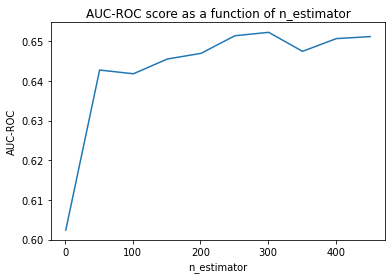

In [5]:
"""Let's study the effect of number of tree on the AUC-ROC score"""

n_estimators = [i for i in range(1,500,50)]
AUR_ROC = []

for n in n_estimators:

    # define the RF model
    RF_model = RandomForestClassifier(n_estimators=n,random_state=42)

    # fit the model
    RF_model.fit(X_train, y_train)

    # predict the test set
    y_pred = RF_model.predict(X_test)

    # compute the roc_auc_score
    roc_auc = roc_auc_score(y_test, y_pred)
    AUR_ROC.append(roc_auc)


# plot the AUC-ROC score as a function of C

plt.plot(n_estimators,AUR_ROC)
plt.xlabel('n_estimator')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC score as a function of n_estimator')
plt.show()

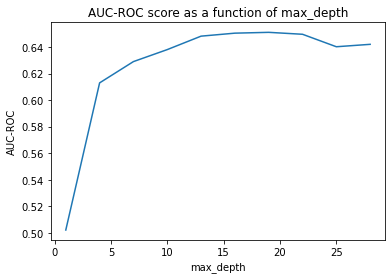

In [12]:
"""Let's study the effect of the max_depth on the AUC-ROC score"""

max_depths = [i for i in range(1,30,3)]
AUR_ROC = []

for max in max_depths:

    # define the RF model
    RF_model = RandomForestClassifier(max_depth=max,random_state=42)

    # fit the model
    RF_model.fit(X_train, y_train)

    # predict the test set
    y_pred = RF_model.predict(X_test)

    # compute the roc_auc_score
    roc_auc = roc_auc_score(y_test, y_pred)
    AUR_ROC.append(roc_auc)

# plot the AUC-ROC score as a function of max_depth

plt.plot(max_depths,AUR_ROC)
plt.xlabel('max_depth')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC score as a function of max_depth')
plt.show()


## Optimization of hyperparameters


In [15]:
"""Let's use optuna first to find a relevant grid for the gridsearch"""

def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 1, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    # Train RF with suggested hyperparameters using cross-validation
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)

    # Perform cross-validation with 5 folds
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')

    # Calculate mean accuracy
    roc_auc = scores.mean()
    
    return roc_auc

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train RF with best hyperparameters on the entire dataset
best_RF = RandomForestClassifier(**best_params, random_state=42)
best_RF.fit(X_train, y_train)

# Predict on test set
y_pred = best_RF.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"roc_auc_score: {roc_auc}")

[I 2024-04-16 10:27:18,463] A new study created in memory with name: no-name-97800867-c684-46fd-b6bc-52785676da90
[I 2024-04-16 10:27:35,939] Trial 0 finished with value: 0.75726980773082 and parameters: {'n_estimators': 347, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.75726980773082.
[I 2024-04-16 10:27:51,506] Trial 1 finished with value: 0.7563505743621464 and parameters: {'n_estimators': 396, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.75726980773082.
[I 2024-04-16 10:28:00,556] Trial 2 finished with value: 0.7565979251709957 and parameters: {'n_estimators': 294, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.75726980773082.
[I 2024-04-16 10:28:02,612] Trial 3 finished with value: 0.7501870466150178 and parameters: {'n_estimators': 61, 'max_depth': 21, 'min_samples

Best Hyperparameters: {'n_estimators': 347, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
roc_auc_score: 0.6307026307026307


In [19]:
"""Let's use gridsearch to find the best hyperparameters"""

# Define the model
RF_model = RandomForestClassifier(random_state=42)

# Define the grid of hyperparameters
param_grid = {'n_estimators': [100, 150, 200], 'max_depth': [5, 10, 15], 'max_features': ['auto', 'sqrt', 'log2']}

# Create the grid search object
grid_search = GridSearchCV(estimator=RF_model, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and the best accuracy
print("Best hyperparameters :", grid_search.best_params_)
print("Best roc_auc :", grid_search.best_score_)

# Evaluate the model
best_svm_model = grid_search.best_estimator_
predictions = best_svm_model.predict(X_test)
roc_auc = roc_auc_score(y_test, predictions)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTr

## Learning curve


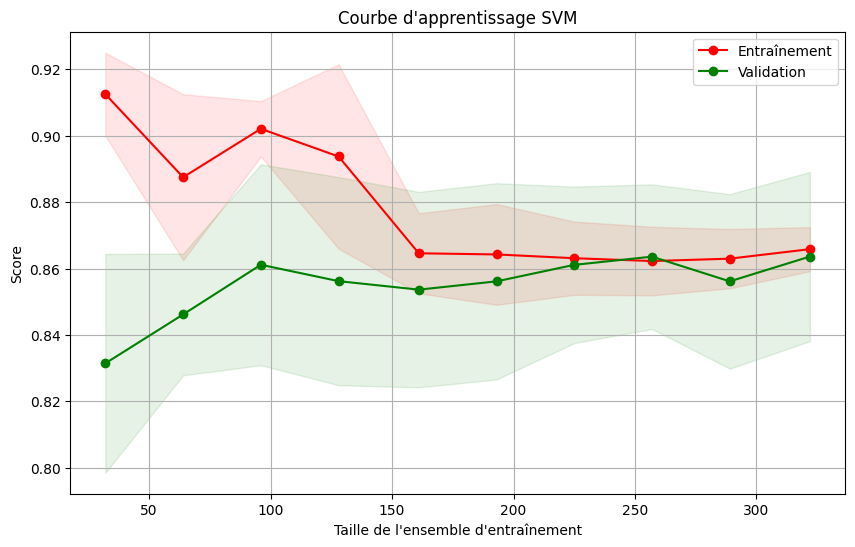

In [ ]:
# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_svm_model, X,  y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),scoring='roc_auc')

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('RF Learning Curve')
plt.xlabel('Training dataset size')
plt.ylabel('Score')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")

plt.legend(loc="best")
plt.show()


# **Interpretability**

In this part, we will apply SHAP and LIME methods to interpret the SVM model.

## LIME

In [16]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train.values, feature_names = X_train.columns, class_names=['False','True'], mode = 'classification')

# Select instance to explain
instance_idx = 0

# Explain prediction
explanation = explainer.explain_instance(X_test.iloc[instance_idx], best_svm_model.predict_proba)

# Show explanation
explanation.show_in_notebook()

NameError: name 'best_svm_model' is not defined

## SHAP

In [17]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(best_svm_model.predict,X_train.sample(frac = 0.2 , random_state = 42))
shap_values = explainer.shap_values(X_test.sample(frac = 0.2, random_state = 42))


  0%|          | 0/16 [00:00<?, ?it/s]

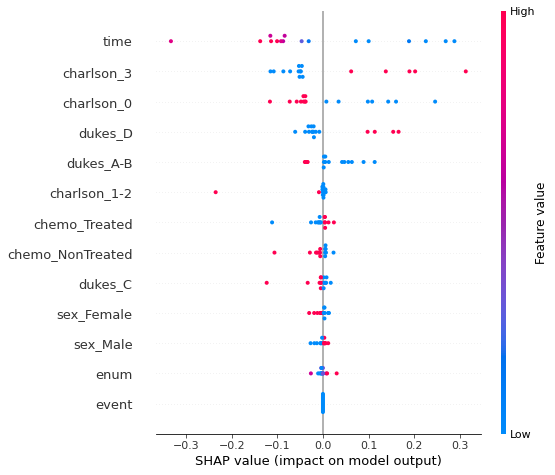

In [19]:
shap.summary_plot(shap_values,X_test.sample(frac = 0.2, random_state = 42))